# <b> Chapter 6

In [87]:
from decimal import Decimal, getcontext
import matplotlib
import matplotlib.pyplot as plt
import enum
import random

TIMES = 10_000
random.seed(23)
getcontext().prec = 4

In [88]:
def rounder(val=2):
    def outer(fn):
        def inner(*args, **kwargs):
            res = fn(*args, **kwargs)
            return round(res, val)
        return inner
    return outer

## Conditional Probability

In [89]:
# Calculating the probablity of children genders

# No girls -> 1/2 * 1/2 = 1/4
# Two girls -> 1/2 * 1/2 = 1/4. Same as above.
# One girl, one boy (vice-versa) -> 1/2 * 1/2 + 1/2 * 1/2 = 1/2.
# Both children are girls, given that at least one of them is a girl (conditional). 1/2 or 1/3 (two scenarios)


class Child(enum.IntEnum):
    BOY = 0
    GIRL = 1


def rand_child() -> Child:
    return random.choice([Child.BOY, Child.GIRL])


# The first has to be a boy as well as the second one
@rounder()
def no_girls() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        if rand_child() == Child.BOY:
            boy += 1
        else:
            girl += 1
    # Probability of a boy given all scenarios.
    first_child = (boy / (boy + girl))
    return first_child * first_child  # Independent events


# Same as above
@rounder()
def two_girls() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        if rand_child() == Child.BOY:
            boy += 1
        else:
            girl += 1
    # Probability of a boy given all scenarios.
    first_child = (girl / (boy + girl))
    return first_child * first_child  # Independent events


# The first can either be a girl or a boy (1/2*1/2), but the second must be a boy or a girl in that order.
@rounder()
def girl_boy() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        first_child = rand_child()
        second_child = rand_child()
        if first_child == Child.BOY:
            boy += 1
            if second_child == Child.GIRL:
                girl += 1
        if first_child == Child.GIRL:
            girl += 1
            if second_child == Child.BOY:
                boy += 1

    boy_girl = (boy / (boy+girl)) * (girl / (boy + girl))  # Boy and girl
    girl_boy = (girl / (boy + girl)) * (boy / (boy+girl))  # Girl and boy
    return boy_girl + girl_boy

@rounder()
def girl_girl(mol=0) -> float:
    both_girls = 0
    older_girl = 0
    either_girl = 0
    for _ in range(TIMES):
        first_child = rand_child()
        second_child = rand_child()
        if first_child == Child.GIRL:
            older_girl += 1
        if first_child == Child.GIRL and second_child == Child.GIRL:
            both_girls += 1
        if first_child == Child.GIRL or second_child == Child.GIRL:
            either_girl += 1
    match mol:
        case 0: return both_girls / older_girl
        case 1: return  both_girls / either_girl


print(f'P(B) = {no_girls()}\nP(G) = {two_girls()}\nP(G,B) = {girl_boy()}\nP(B|L) = {girl_girl(0)}\nP(B|G) = {girl_girl(1)}')

P(B) = 0.26
P(G) = 0.24
P(G,B) = 0.5
P(B|L) = 0.51
P(B|G) = 0.33


## Bayes’s Theorem

\begin{gather*}
P(A\vert B) = \frac{{P(B\vert A) \cdot P(A)}}{{P(B)}}
\end{gather*}

\begin{gather*}
or
\end{gather*}

\begin{gather*}
P(A\vert B) = \frac{{P(B\vert A) \cdot P(B)}}{{(P(B\vert A) \cdot P(B)) + (P(B\vert ¬A) \cdot P(¬B))}}
\end{gather*}

Given a disease and a test that:
<ul>
<li>
Affects 1 for every 10.000 people
</li>
<li>
Has 98% of sensitivity (correctly identify those with the disease)
</li>
</ul>

<b> What is the probability that one that tested positive have a disease?  

In [90]:
def p_dt() -> float:
    """Calculates the probability that one that tested positive have a disease"""
    p_d = Decimal('1') / Decimal('10_000')
    p_notd = Decimal('1') - p_d 
    p_td = Decimal('0.98')
    p_tnotd = Decimal('1') - p_td
    return p_td * p_d / ((p_td * p_d) + (p_tnotd * p_notd))
    

print(f'P(D|T): {p_dt()}\nThat is, 99,952% of the positive tests are false positives\n(Test errors are relatively common - one in 100 - compared with cases of the disease).') 

P(D|T): 0.004876
That is, 99,952% of the positive tests are false positives
(Test errors are relatively common - one in 100 - compared with cases of the disease).


## Continuous Distribution

### In Uniform Distributions we have:

#### - Probability Density Function (PDF):

$$
\begin{gather*}
{\displaystyle f(x)={\begin{cases}{\frac {1}{b-a}}&{\text{for }}a\leq x\leq b,\\[8pt]0&{\text{for }}x<a\ {\text{ or }}\ x>b.\end{cases}}}
\end{gather*}
$$



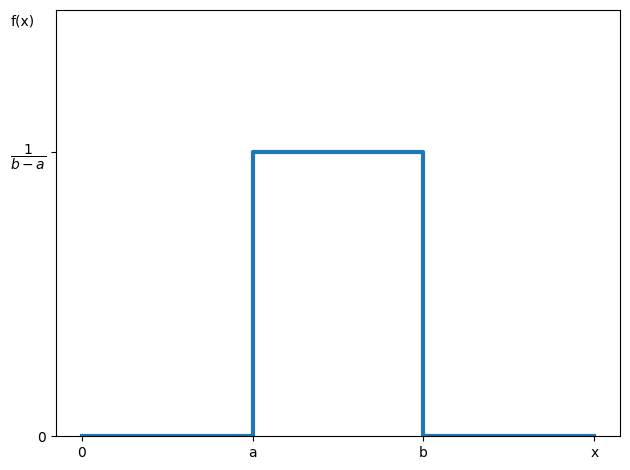

In [157]:
# Plotting the graph

x = ["0", "a", "a", "b", "b", "x"]
y = ["0", "0", r"$\dfrac{1}{b-a}$",  r"$\dfrac{1}{b-a}$", "0", "0"]
ax = plt.subplot()
ax.plot(x, y, linewidth=3)
ticklabelpad = matplotlib.rcParams['xtick.major.pad']
ax.annotate('f(x)', xy=(-0.1,1), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.ylim(top=1.5, bottom=0)
plt.tight_layout(h_pad=-20)
plt.show()

#### - Cumulative Distribution Function:

$$
\begin{gather*}
{\displaystyle F(x)={\begin{cases}0&{\text{for }}x<a,\\[8pt]{\frac {x-a}{b-a}}&{\text{for }}a\leq x\leq b,\\[8pt]1&{\text{for }}x>b.\end{cases}}}
\end{gather*}
$$

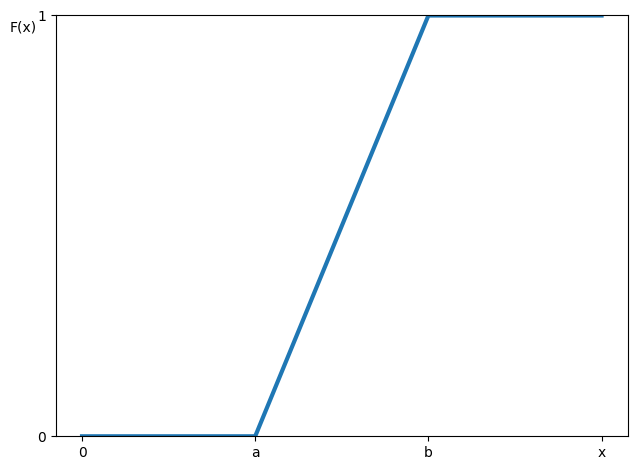

In [174]:
x = ["0", "a", "b", "x"]
y = ["0", "0", "1", "1"]
ax = plt.subplot()
ax.plot(x, y, linewidth=3)
ticklabelpad = matplotlib.rcParams['xtick.major.pad']
ax.annotate('F(x)', xy=(-0.1,1), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.ylim(top=1, bottom=0)
plt.tight_layout(h_pad=-20)
plt.show()